In [73]:
import sys
import calendar
import glob

import xarray as xr
import dask.diagnostics
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cmocean
import pandas as pd

sys.path.append('/g/data/wp00/shared_code/qqscale')
import utils

In [74]:
dask.diagnostics.ProgressBar().register()

In [102]:
adjustment_file = '/g/data/wp00/users/dbi599/npcp/tmin-qm-additive-monthly-bias-vs-AGCD_AUS-15_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_198001-199912_AWAP.nc'
bc_file = '/g/data/wp00/users/dbi599/npcp/tmin_AUS-15_CSIRO-BOM-ACCESS-CM2_historical-ssp370_r4i1p1f1_BOM-BARPA-R_v1_day_200001-201912_AWAP_qmba-additive-monthly-AGCD-19800101-19991231.nc'
target_q_file = '/g/data/wp00/users/dbi599/npcp/tasmin-quantiles_AUS-15_CSIRO-BOM-ACCESS-CM2_historical-ssp370_r4i1p1f1_BOM-BARPA-R_v1_day_200001-201912_AWAP.nc'
# omeo
example_lat = -37.1
example_lon = 147.6
example_month = 5
model_units = "K"
obs_units = "C"
output_units = "C"
model_var = "tasmin"
obs_var = "tmin"
hist_files1 = glob.glob('/g/data/tp28/ACS_DRS_v1_AWAP/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmin/tasmin_AUS-15_CSIRO-BOM-ACCESS-CM2_historical_r4i1p1f1_BOM-BARPA-R_v1_day_19[8,9]*_AWAP.nc')
hist_files2 = glob.glob('/g/data/tp28/ACS_DRS_v1_AWAP/CSIRO-BOM-ACCESS-CM2/historical/r4i1p1f1/BOM-BARPA-R/v1/day/tasmin/tasmin_AUS-15_CSIRO-BOM-ACCESS-CM2_*_r4i1p1f1_BOM-BARPA-R_v1_day_20[0,1]*_AWAP.nc')
fut_files = glob.glob('/g/data/tp28/ACS_DRS_v1_AWAP/CSIRO-BOM-ACCESS-CM2/ssp370/r4i1p1f1/BOM-BARPA-R/v1/day/tasmin/tasmin_AUS-15_CSIRO-BOM-ACCESS-CM2_*_r4i1p1f1_BOM-BARPA-R_v1_day_20[0,1]*_AWAP.nc')
model_files = hist_files1 + hist_files2 + fut_files
model_files.sort()
obs_files = '/g/data/xv83/agcd-csiro/tmin/daily/tmin_AGCD-CSIRO_r005_19100101-20220405_daily_space-chunked.zarr'
training_time_bounds = "1980-01-01 1999-12-31"
assessment_time_bounds = "2000-01-01 2019-12-31"

training_time_bounds = training_time_bounds.split()
assessment_time_bounds = assessment_time_bounds.split()

In [103]:
point_selection = {'lat': example_lat, 'lon': example_lon}

In [125]:
plot_config = {}
if hist_var == 'tasmin':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [-4.0, -2.5, -1, 0.5, 2, 3.5, 5, 6.5, 8, 9.5, 11, 12.5, 14, 15.5, 17, 18.5, 20, 21.5, 23, 24.5]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
elif hist_var == 'tasmax':
    plot_config['regular_cmap'] = cmocean.cm.thermal
    plot_config['diverging_cmap'] = 'RdBu_r'
    plot_config['general_levels'] = [5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
    plot_config['af_levels'] = None
    plot_config['difference_levels'] = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2]
elif hist_var == 'pr':
    plot_config['regular_cmap'] = cmocean.cm.rain
    plot_config['diverging_cmap'] = 'BrBG'
    plot_config['general_levels'] = [0, 0.01, 10, 20, 30, 40, 50, 60, 70, 80, 90]
    plot_config['af_levels'] = [0.125, 0.25, 0.5, 0.67, 0.8, 1, 1.25, 1.5, 2, 4, 8]
    plot_config['difference_levels'] = [-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
else:
    raise ValueError(f'No plotting configuration defined for {hist_var}')

In [105]:
ds_model = utils.read_data(
    model_files,
    model_var,
    input_units=model_units,
    output_units=output_units,
)
ds_model[hist_var]

<xarray.DataArray 'tasmin' (time: 14610, lat: 691, lon: 886)>
dask.array<rechunk-merge, shape=(14610, 691, 886), dtype=float32, chunksize=(14610, 691, 886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2019-12-31T12:00:00
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    units:          C
    cell_methods:   time: minimum (interval: 1 hour) time: minimum (interval:...

In [106]:
ds_model_training = ds_model.sel(time=slice(training_time_bounds[0], training_time_bounds[1]))
da_model_training = ds_model_training[model_var].sel(point_selection, method='nearest')

In [107]:
ds_model_assessment = ds_model.sel(time=slice(assessment_time_bounds[0], assessment_time_bounds[1]))
da_model_assessment = ds_model_assessment[model_var].sel(point_selection, method='nearest')

In [108]:
ds_obs = utils.read_data(
    obs_files,
    obs_var,
    input_units=obs_units,
    output_units=output_units,
)
ds_obs[obs_var]

/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/g/data/xv83/dbi599/miniconda3/envs/qqscale/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


,Array,Chunk
Bytes,93.52 GiB,15.64 MiB
Shape,"(41003, 691, 886)","(41003, 10, 10)"
Count,6231 Tasks,6230 Chunks
Type,float32,numpy.ndarray


In [109]:
ds_obs_training = ds_obs.sel(time=slice(training_time_bounds[0], training_time_bounds[1]))
da_obs_training = ds_obs_training[obs_var].sel(point_selection, method='nearest')

In [110]:
ds_obs_assessment = ds_obs.sel(time=slice(assessment_time_bounds[0], assessment_time_bounds[1]))
da_obs_assessment = ds_obs_assessment[obs_var].sel(point_selection, method='nearest')

In [111]:
ds_adjust = xr.open_dataset(adjustment_file)

In [112]:
ds_adjust

<xarray.Dataset>
Dimensions:    (lon: 886, lat: 691, month: 12, quantiles: 100)
Coordinates:
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat        (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
Data variables:
    af         (quantiles, month, lat, lon) float32 ...
    hist_q     (quantiles, month, lat, lon) float32 ...
    ref_q      (quantiles, month, lat, lon) float32 ...
    hist_clim  (lat, lon) float32 ...
    ref_clim   (lat, lon) float32 ...
Attributes:
    _xclim_adjustment:        {"py/object": "xclim.sdba.adjustment.EmpiricalQ...
    adj_params:               EmpiricalQuantileMapping(group=Grouper(add_dims...
    history:                  Tue Feb 14 10:58:55 2023: /g/data/xv83/dbi599/m...
    historical_period_start:  1980-01-01
    historical_period_end:    1999-12-31
    reference_period_start:   1980-01-01
    reference_period_end:     1999-12-31
    xclim_version:            0.36.0

In [113]:
target_q = xr.open_dataset(target_q_file)

In [114]:
target_q

<xarray.Dataset>
Dimensions:    (quantiles: 100, lat: 691, lon: 886, month: 12)
Coordinates:
  * quantiles  (quantiles) float64 0.005 0.015 0.025 0.035 ... 0.975 0.985 0.995
  * lat        (lat) float64 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon        (lon) float64 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tasmin     (quantiles, month, lat, lon) float32 ...
Attributes:
    history:  Tue Feb 14 12:08:27 2023: /g/data/xv83/dbi599/miniconda3/envs/q...

In [115]:
ds_bc = xr.open_dataset(bc_file)

In [117]:
da_bc = ds_bc[target_var].sel(point_selection, method='nearest')

In [118]:
lat_min_bc = ds_bc['lat'].values.min()
lat_max_bc = ds_bc['lat'].values.max()
lon_min_bc = ds_bc['lon'].values.min()
lon_max_bc = ds_bc['lon'].values.max()

In [119]:
print(lat_min_bc, lat_max_bc, lon_min_bc, lon_max_bc)

-44.5 -10.0 112.0 156.25


In [120]:
def quantile_month_plot(da, ax, cmap_type, levels=None, extend='both', point=None, title=None):
    """Create two dimensional month/quantile plot"""
    
    assert cmap_type in ['regular', 'diverging']
    
    quantiles = da.sel(point_selection, method='nearest')
    
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(quantiles.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
    
    quantiles.transpose('month', 'quantiles').plot(ax=ax, cmap=cmap, extend=extend, **kwargs)
    
    yticks = np.arange(1,13)
    ytick_labels = [calendar.month_abbr[i] for i in yticks]
    ax.set_yticks(yticks, ytick_labels)
    ax.invert_yaxis()
    if title:
        ax.set_title(title)

In [121]:
def quantile_spatial_plot(
    da, month, cmap_type, lat_bounds=None, lon_bounds=None, levels=None,
):
    """Spatial plot of the 10th, 50th and 90th percentile"""
    
    da_selection = da.sel({'quantiles': [.1, .5, .9], 'month': month}, method='nearest')
    if lat_bounds:
        lat_min, lat_max = lat_bounds
        da_selection = da_selection.sel(lat=slice(lat_min, lat_max))
    if lon_bounds:
        lon_min, lon_max = lon_bounds
        da_selection = da_selection.sel(lon=slice(lon_min, lon_max))
        
    cmap = plot_config[f'{cmap_type}_cmap']
    kwargs = {}
    if levels:
        kwargs['levels'] = levels
    elif cmap_type == 'diverging':
        abs_max = np.max(np.abs(da_selection.values))
        vmax = abs_max
        vmin = -1 * abs_max
        kwargs['vmax'] = vmax
        kwargs['vmin'] = vmin
        
    p = da_selection.plot(
        col='quantiles',
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        figsize=[20, 5.5],
        subplot_kws={'projection': ccrs.PlateCarree(),},
        **kwargs,
    )
    for ax in p.axes.flat:
        ax.coastlines()
        ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
    plt.suptitle(calendar.month_name[month])
    plt.show()

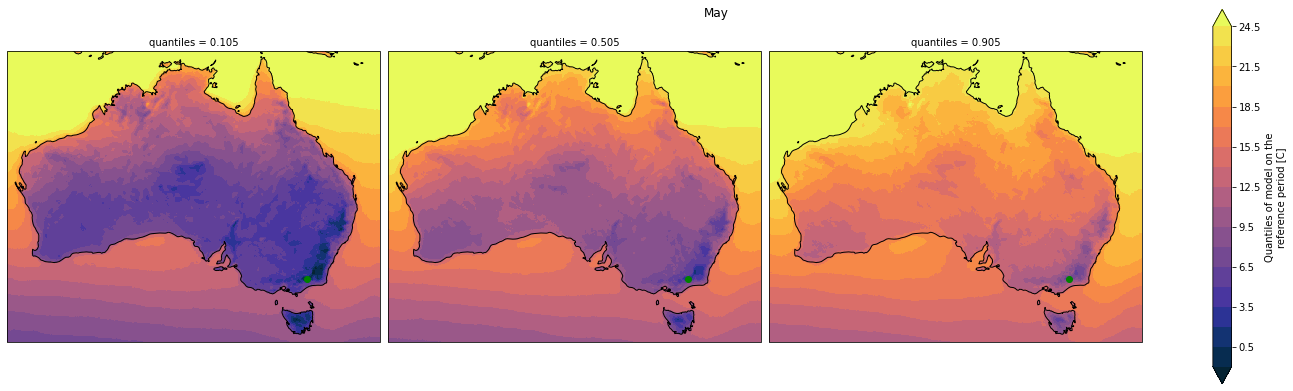

In [122]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['hist_q'],
        example_month,
        'regular',
        levels=plot_config['general_levels'],
        lat_bounds=[lat_min_bc, lat_max_bc],
        lon_bounds=[lon_min_bc, lon_max_bc],
    )

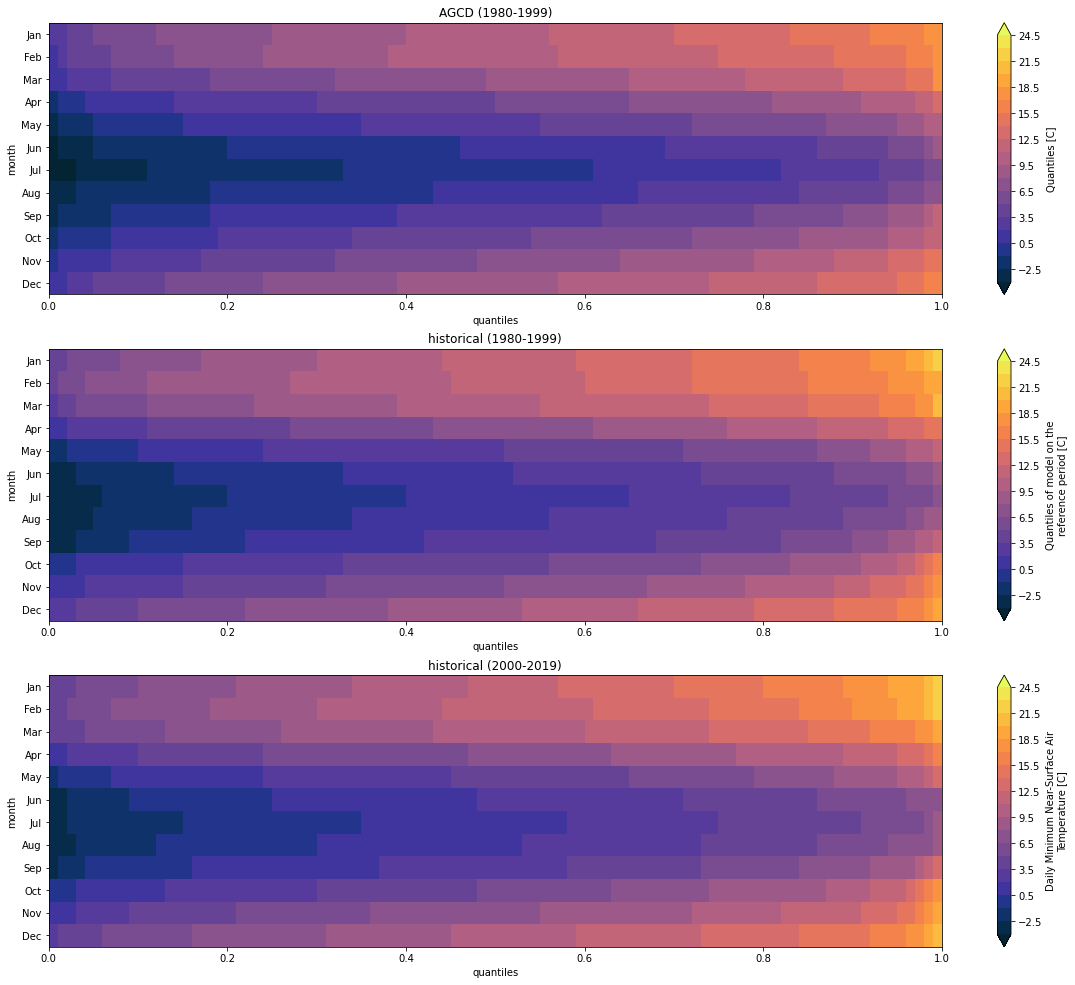

In [126]:
fig = plt.figure(figsize=[20, 17])
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

quantile_month_plot(
    ds_adjust['ref_q'],
    ax1,
    'regular',
    levels=plot_config['general_levels'],
    title='AGCD (1980-1999)',
    extend='both',
)

quantile_month_plot(
    ds_adjust['hist_q'],
    ax2,
    'regular',
    levels=plot_config['general_levels'],
    title='historical (1980-1999)',
    extend='both',
)

quantile_month_plot(
    target_q[target_var],
    ax3,
    'regular',
    levels=plot_config['general_levels'],
    title='historical (2000-2019)',
    extend='both',
)

plt.show()

[########################################] | 100% Completed | 54.7s
[########################################] | 100% Completed | 54.7s
[########################################] | 100% Completed | 54.8s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s


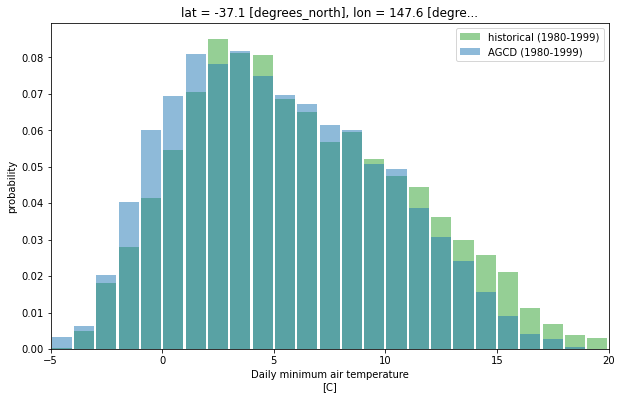

In [127]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(-5, 150, 1)    

da_model_training.plot.hist(
    bins=bins,
    density=True,
    label='historical (1980-1999)',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)

da_obs_training.plot.hist(
    bins=bins,
    density=True,
    label='AGCD (1980-1999)',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(-5, 20)
plt.legend()
plt.show()

In [128]:
da_model_training.values.mean()

[########################################] | 100% Completed | 54.5s
[########################################] | 100% Completed | 54.5s
[########################################] | 100% Completed | 54.5s


6.1578536

In [129]:
da_obs_training.values.mean()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s


5.245841

[########################################] | 100% Completed | 52.9s
[########################################] | 100% Completed | 53.0s
[########################################] | 100% Completed | 53.1s


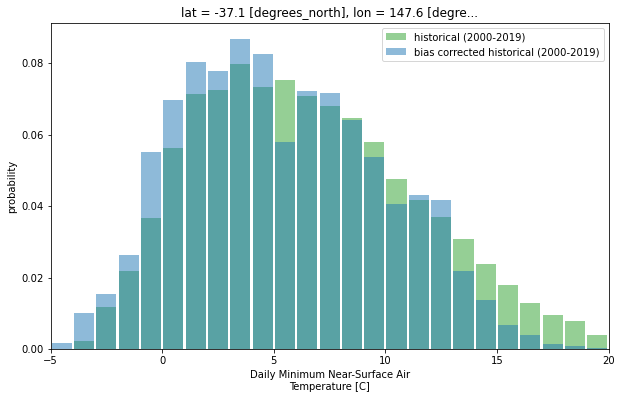

In [130]:
fig = plt.figure(figsize=[10, 6])

bins = np.arange(-5, 150, 1)    

da_model_assessment.plot.hist(
    bins=bins,
    density=True,
    label='historical (2000-2019)',
    facecolor='tab:green',
    alpha=0.5,
    rwidth=0.9,
)

da_bc.plot.hist(
    bins=bins,
    density=True,
    label='bias corrected historical (2000-2019)',
    facecolor='tab:blue',
    alpha=0.5,
    rwidth=0.9,
)
plt.ylabel('probability')
plt.xlim(-5, 20)
plt.legend()
plt.show()

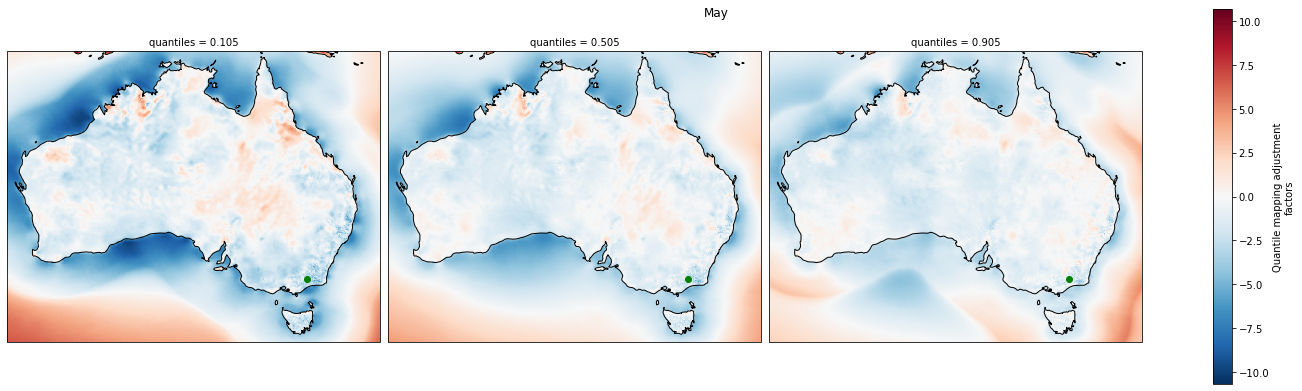

In [131]:
if 'lat' in ds_adjust.dims:
    quantile_spatial_plot(
        ds_adjust['af'],
        example_month,
        'diverging',
        levels=plot_config['af_levels'],
        lat_bounds=[lat_min_bc, lat_max_bc],
        lon_bounds=[lon_min_bc, lon_max_bc],
    )

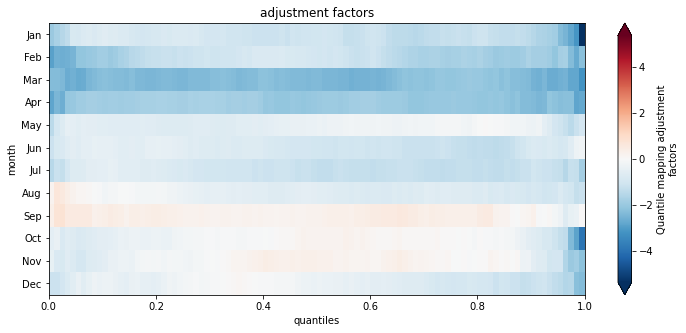

In [132]:
fig = plt.figure(figsize=[12, 5])
ax1 = fig.add_subplot(111)

quantile_month_plot(
    ds_adjust['af'],
    ax1,
    'diverging',
    levels=plot_config['af_levels'],
    title='adjustment factors'
)

plt.show()

In [134]:
model_training_clim = ds_model_training[model_var].mean('time', keep_attrs=True)
obs_training_clim = ds_obs_training[obs_var].mean('time', keep_attrs=True)
model_assessment_clim = ds_model_assessment[model_var].mean('time', keep_attrs=True)
bc_clim = ds_bc[target_var].mean('time', keep_attrs=True)

In [135]:
model_training_clim['lat'] = bc_clim['lat']
model_training_clim['lon'] = bc_clim['lon']

obs_training_clim['lat'] = bc_clim['lat']
obs_training_clim['lon'] = bc_clim['lon']

model_assessment_clim['lat'] = bc_clim['lat']
model_assessment_clim['lon'] = bc_clim['lon']

In [136]:
training_mean_bias = model_training_clim - obs_training_clim
training_mean_bias = training_mean_bias.compute()

[########################################] | 100% Completed |  1min 52.6s
[########################################] | 100% Completed |  1min 52.7s
[########################################] | 100% Completed |  1min 52.8s


[########################################] | 100% Completed |  2min  6.6s
[########################################] | 100% Completed |  2min  6.6s
[########################################] | 100% Completed |  2min  6.7s
[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.8s
[########################################] | 100% Completed | 44.8s


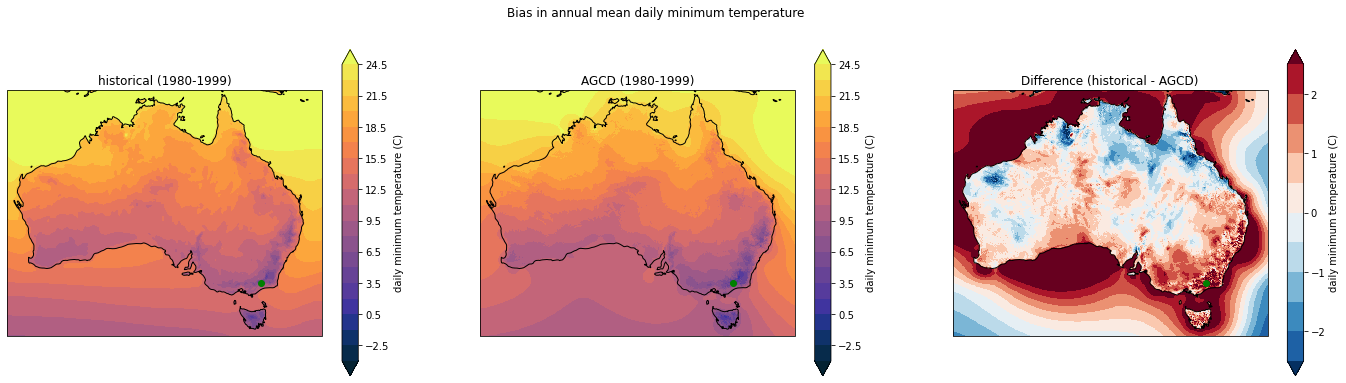

In [137]:
fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
model_training_clim.plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['regular_cmap'],
    levels=plot_config['general_levels'],
    extend='both',
    cbar_kwargs={'label': 'daily minimum temperature (C)'}
)
ax1.set_title('historical (1980-1999)')

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
obs_training_clim.plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['regular_cmap'],
    levels=plot_config['general_levels'],
    extend='both',
    cbar_kwargs={'label': 'daily minimum temperature (C)'}
)
ax2.set_title('AGCD (1980-1999)')

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
training_mean_bias.plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),
    cmap=plot_config['diverging_cmap'],
    levels=[-2.5, -2.0, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2.0, 2.5],
    extend='both',
    cbar_kwargs={'label': 'daily minimum temperature (C)'}
)
ax3.set_title('Difference (historical - AGCD)')

for ax in [ax1, ax2, ax3]:
    ax.coastlines()
    ax.plot(example_lon, example_lat, 'go', zorder=5, transform=ccrs.PlateCarree())
xmin, xmax = ax3.get_xlim()
ymin, ymax = ax3.get_ylim()
ax1.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
ax2.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.PlateCarree())
plt.suptitle('Bias in annual mean daily minimum temperature')
plt.show()